# Ex8 Q4: Policy-gradient methods

In [1]:
from collections import deque, namedtuple
from gymnasium import spaces
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.distributions import Categorical
import torch.nn.functional as F
import tqdm

## Four Rooms environment

In the question, we will implement several policy-gradient methods and apply them once again on our favorite domain, Four Rooms. The environment is implemented below in a Gymnasium-like interface. Code for plotting learning curves with confidence bands is also provided.

In [2]:
DENSE_REWARDS = True

class FourRooms(object):
    def __init__(self):
        # The grid for the Four Rooms domain
        self.grid = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

        # Observation (state) space consists of all empty cells
        # To improve interpretability, we flip the coordinates from (row_idx, column_idx) -> (x, y),
        # where x = column_idx, y = 10 - row_idx
        self.observation_space = np.argwhere(self.grid == 0.0).tolist()  # Fine all empty cells
        self.observation_space = self.arr_coords_to_four_room_coords(self.observation_space)

        # Action space
        self.action_movement = {0: np.array([0, 1]),  # up
                                1: np.array([0, -1]),  # down
                                2: np.array([-1, 0]),  # left
                                3: np.array([1, 0])}  # right
        self.action_space = spaces.Discrete(4)

        # Start location
        self.start_location = [0, 0]

        # Goal location
        self.goal_location = [10, 10]

        # Wall locations
        self.walls = np.argwhere(self.grid == 1.0).tolist()  # find all wall cells
        self.walls = self.arr_coords_to_four_room_coords(self.walls)  # convert to Four Rooms coordinates

        # This is an episodic task, with a timeout of 459 steps
        self.max_time_steps = 459

        # Tracking variables during a single episode
        self.agent_location = None  # Track the agent's location in one episode.
        self.action = None  # Track the agent's action
        self.t = 0  # Track the current time step in one episode

    @staticmethod
    def arr_coords_to_four_room_coords(arr_coords_list):
        """
        Function converts the array coordinates ((row, col), origin is top left)
        to the Four Rooms coordinates ((x, y), origin is bottom left)
        E.g., The coordinates (0, 0) in the numpy array is mapped to (0, 10) in the Four Rooms coordinates.
        Args:
            arr_coords_list (list): List variable consisting of tuples of locations in the numpy array

        Return:
            four_room_coords_list (list): List variable consisting of tuples of converted locations in the
                                          Four Rooms environment.
        """
        # Flip the coordinates from (row_idx, column_idx) -> (x, y),
        # where x = column_idx, y = 10 - row_idx
        four_room_coords_list = [(column_idx, 10 - row_idx) for (row_idx, column_idx) in arr_coords_list]
        return four_room_coords_list

    def reset(self):
        # Reset the agent's location to the start location
        self.agent_location = self.start_location

        # Reset the timeout tracker to be 0
        self.t = 0

        # Reset the information
        info = {}
        return self.agent_location, info

    def step(self, action):
        """
        Args:
            action (int): Int variable (i.e., 0 for "up"). See self.action_movement above for more details.
        """
        # With probability 0.8, the agent takes the correct direction.
        # With probability 0.2, the agent takes one of the two perpendicular actions.
        # For example, if the correct action is "LEFT", then
        #     - With probability 0.8, the agent takes action "LEFT";
        #     - With probability 0.1, the agent takes action "UP";
        #     - With probability 0.1, the agent takes action "DOWN".
        if np.random.uniform() < 0.2:
            if action == 2 or action == 3:
                action = np.random.choice([0, 1], 1)[0]
            else:
                action = np.random.choice([2, 3], 1)[0]

        # Convert the agent's location to array
        loc_arr = np.array(self.agent_location)

        # Convert the action name to movement array
        act_arr = self.action_movement[action]

        # Compute the agent's next location
        next_agent_location = np.clip(loc_arr + act_arr,
                                      a_min=np.array([0, 0]),
                                      a_max=np.array([10, 10])).tolist()

        # Check if the agent crashes into walls; if so, it stays at the current location.
        if tuple(next_agent_location) in self.walls:
            next_agent_location = self.agent_location

        # Compute the reward (1 iff next state is goal location)
        if DENSE_REWARDS:
            reward = 0.0 if next_agent_location == self.goal_location else -1.0
        else:
            reward = 1.0 if next_agent_location == self.goal_location else 0.0

        # Check termination/truncation
        # If agent reaches the goal, reward = 1, terminated = True
        # If timeout is reached, reward = 0, truncated = True
        terminated = False
        truncated = False
        if reward == 1.0:
            terminated = True
        elif self.t == self.max_time_steps:
            truncated = True

        # Update the agent's location, action, and time step trackers
        self.agent_location = next_agent_location
        self.action = action
        self.t += 1

        return next_agent_location, reward, terminated, truncated, {}

    def render(self):
        # Plot the agent and the goal
        # empty cell = 0
        # wall cell = 1
        # agent cell = 2
        # goal cell = 3
        plot_arr = self.grid.copy()
        plot_arr[10 - self.agent_location[1], self.agent_location[0]] = 2
        plot_arr[10 - self.goal_location[1], self.goal_location[0]] = 3
        plt.clf()
        plt.title(f"state={self.agent_location}, act={self.action_movement[self.action]}")
        plt.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(0.1)

    @staticmethod
    def test():
        env = FourRooms()
        state, info = env.reset()

        for _ in range(1000):
            action = env.action_space.sample()
            next_state, reward, terminated, truncated, info = env.step(action)
            env.render()
            if terminated or truncated:
                state, info = env.reset()
            else:
                state = next_state

# Un-comment to run test function
# FourRooms.test()

In [3]:
def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

In [4]:
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title, smoothing = True):
    """
    Args:
        arr_list (list): List of results arrays to plot
        legend_list (list): List of legends corresponding to each result array
        color_list (list): List of color corresponding to each result array
        ylabel (string): Label of the vertical axis

        Make sure the elements in the arr_list, legend_list, and color_list
        are associated with each other correctly (in the same order).
        Do not forget to change the ylabel for different plots.
    """
    # Set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the vertical labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # Plot results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # Compute the standard error (of raw data, not smoothed)
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # Plot the mean
        averages = moving_average(arr.mean(axis=0)) if smoothing else arr.mean(axis=0)
        h, = ax.plot(range(arr.shape[1]), averages, color=color, label=legend)
        # Plot the confidence band
        arr_err *= 1.96
        ax.fill_between(range(arr.shape[1]), averages - arr_err, averages + arr_err, alpha=0.3,
                        color=color)
        # Save the plot handle
        h_list.append(h)

    # Plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

    plt.show()

## Part (a): REINFORCE algorithm (page 328)

### Policy network

We will use and learn a neural network to represent the stochastic policy $\pi(a|s)$. The architecture of the neural network should be:

Layer 1: Linear, input size 3 (size of observation space, see below), output size 128\
Activation 1: ReLU\
Layer 2: Linear, input size 128, output size 4 (size of action space)\
Activation 2: Softmax (to ensure output is a probability distribution)

For the input observation, instead of using the original state = $[x, y]$, we represent each state as $\left[ \frac{x}{10}, \frac{y}{10}, 1 \right]$, which normalizes the input.

In [5]:
class PolicyNet(nn.Module):
    def __init__(self, observation_dim=3, hidden_dim=128, action_dim=4):
        super(PolicyNet, self).__init__()

        """ YOUR CODE HERE:
                Implement the neural network here
        """
        self.hidden_dim = hidden_dim
        self.input_layer = nn.Linear(observation_dim, self.hidden_dim)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(self.hidden_dim, action_dim)
        self.softmax = nn.Softmax()

    def forward(self, x):
        """ YOUR CODE HERE:
                Implement the forward propagation
        """

        x = self.input_layer(x)
        x = self.relu(x)
        x = self.output_layer(x)
        probs = self.softmax(x)

        return probs

### REINFORCE agent with policy network

In [6]:
class REINFORCEAgent(object):
    def __init__(self):
        # Create the policy network
        self.policy_net = PolicyNet()

    def get_action(self, state):
        """ Function to derive an action given a state
            Args:
                state (list): [x/10, y/10, 1]

            Returns:
                action index (int), log_prob (ln(\pi(action|state)))
        """
        state_tensor = torch.tensor(state).float().view(1, -1)
        probs = self.policy_net(state_tensor)
        m = Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        return action.item(), log_prob

### REINFORCE training loop

In [7]:
class REINFORCEAgentTrainer(object):
    def __init__(self, agent, env, params):
        # Agent object
        self.agent = agent

        # Environment object
        self.env = env

        # Training parameters
        self.params = params

        # Lists to store the log probabilities and rewards for one episode
        self.saved_log_probs = []
        self.saved_rewards = []

        # Gamma
        self.gamma = params['gamma']

        # Create the optimizer
        """ YOUR CODE HERE:
                Use the Adam optimizer with the learning rate in params
        """
        self.optimizer = torch.optim.Adam(agent.policy_net.parameters(), lr=params['learning_rate'])

    @staticmethod
    def compute_state_feature(state):
        return [state[0] / 10, state[1] / 10, 1]

    def update_agent_policy_network(self):
        # List to store the policy loss for each time step
        policy_loss = []

        # List to store the return for each time step
        returns = deque()

        """ YOUR CODE HERE:
                Compute the return for each time step

                Hint: We usually compute the return from the end. Remember to append it
                      correctly. You can use "returns.appendleft(G)"
        """
        # Compute returns for every time step

        G = 0
        for reward in reversed(self.saved_rewards):
            G = self.gamma * G + reward
            returns.appendleft(G)

        returns = torch.tensor(returns)

        """ YOUR CODE HERE:
                We now have the return and log probability for each time step.
                Compute the `policy loss' for each time step
                (whose gradient appears in the pseudocode).
        """
        for log_prob, r in zip(self.saved_log_probs, returns):
            # Compute the policy loss for each time step
            policy_loss.append(-log_prob * r)
        # policy_loss = torch.tensor(self.saved_log_probs, requires_grad=True) * -1 * returns

        # Sum all the policy loss terms across all time steps
        policy_loss = torch.cat(policy_loss).sum()
        # policy_loss = policy_loss.sum()

        """ YOUR CODE HERE:
                Implement one step of backpropagation (gradient descent)
        """

        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

        # After backpropagation, clear the data
        del self.saved_log_probs[:]
        del self.saved_rewards[:]

        return returns[0].item(), policy_loss.item()

    def rollout(self):
        """ Function to collect one episode from the environment
        """

        """ YOUR CODE HERE:
                Implement the code to collect one episode.

                Specifically, we only collect the rewards and corresponding log probability, which
                should be stored in "self.saved_rewards" and "self.saved_log_probs", respectively.

                This is because we only need the return at each time step and log probability
                to update the weights of the policy.

        """

        done = False
        state, info = self.env.reset()
        while not done:
            action, log_prob = self.agent.get_action(self.compute_state_feature(state))
            next_state, reward, terminated, truncated, info = self.env.step(action)
            self.saved_log_probs.append(log_prob)
            self.saved_rewards.append(reward)

            done = terminated or truncated
            state = next_state

    def run_train(self):
        # Lists to store the returns and losses during the training
        train_returns = []
        train_losses = []

        # Training loop
        ep_bar = tqdm.trange(self.params['num_episodes'])
        for ep in ep_bar:
            """ YOUR CODE HERE:
                    Implement the REINFORCE algorithm here.
            """
            # Collect one episode
            self.rollout()

            # Update the policy using the collected episode
            G, loss = self.update_agent_policy_network()

            # Save the return and loss
            train_returns.append(G)
            train_losses.append(loss)

            # Add description
            ep_bar.set_description(f"Episode: {ep} | Return: {G} | Loss: {loss:.2f}")

        return train_returns, train_losses

### Evaluation of REINFORCE on Four Rooms

We will run 10 trials with 10K episodes as in past assignments, which will take between 1-2 hours. If this takes too long, you can halve both the trials and number of episodes within each trial. As usual, you should set this to be much lower during development and debugging.

In [22]:
if __name__ == "__main__":
    my_env = FourRooms()

    train_params = {
        'num_episodes': 10000,
        'num_trials': 10,
        'learning_rate': 1e-3,
        'gamma': 0.99
    }

    reinforce_returns = []
    reinforce_losses = []
    for _ in range(train_params['num_trials']):
        my_agent = REINFORCEAgent()
        my_trainer = REINFORCEAgentTrainer(my_agent, my_env, train_params)
        returns, losses = my_trainer.run_train()

        reinforce_returns.append(returns)
        reinforce_losses.append(losses)

Episode: 9999 | Return: 0.7547193169593811 | Loss: 17.20: 100%|██████████| 10000/10000 [07:02<00:00, 23.67it/s]  
Episode: 9999 | Return: 0.5696011781692505 | Loss: 20.47: 100%|██████████| 10000/10000 [06:40<00:00, 24.96it/s]  
Episode: 9999 | Return: 0.4998370409011841 | Loss: 32.10: 100%|██████████| 10000/10000 [06:40<00:00, 24.98it/s]  
Episode: 9999 | Return: 0.5811663866043091 | Loss: 20.00: 100%|██████████| 10000/10000 [06:04<00:00, 27.41it/s]  
Episode: 9999 | Return: 0.530905544757843 | Loss: 32.94: 100%|██████████| 10000/10000 [05:59<00:00, 27.81it/s]  
Episode: 9999 | Return: 0.7177305221557617 | Loss: 26.47: 100%|██████████| 10000/10000 [06:17<00:00, 26.46it/s]  
Episode: 9999 | Return: 0.6757290363311768 | Loss: 14.27: 100%|██████████| 10000/10000 [06:22<00:00, 26.17it/s]  
Episode: 9999 | Return: 0.40473195910453796 | Loss: 32.68: 100%|██████████| 10000/10000 [05:20<00:00, 31.25it/s] 
Episode: 9999 | Return: 0.81790691614151 | Loss: 8.22: 100%|██████████| 10000/10000 [10:0

### Plot learning and loss curves

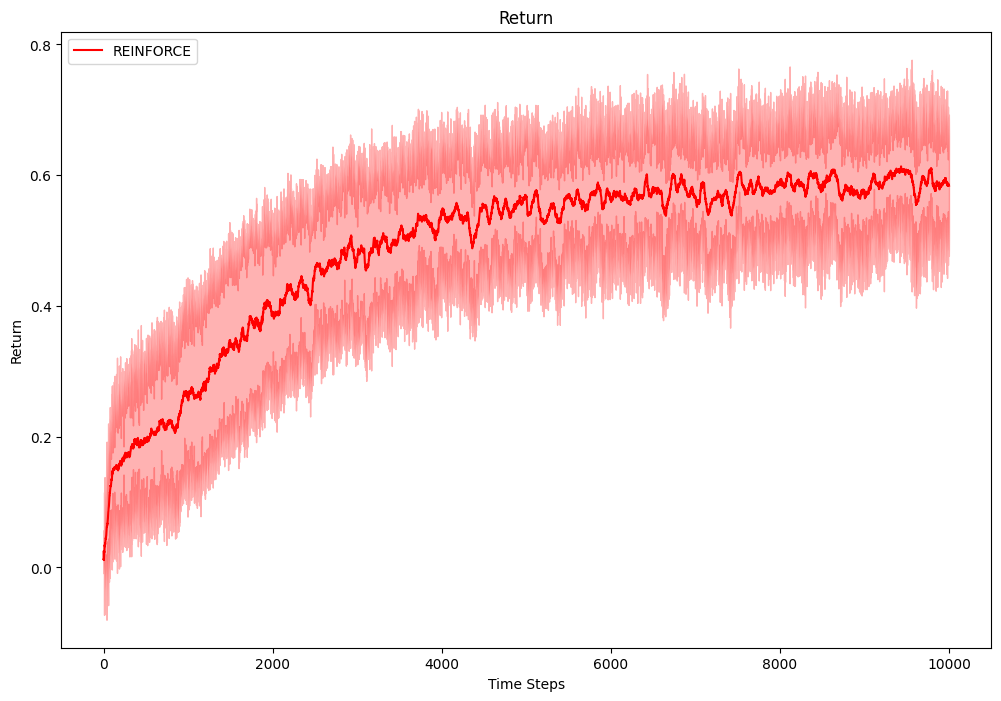

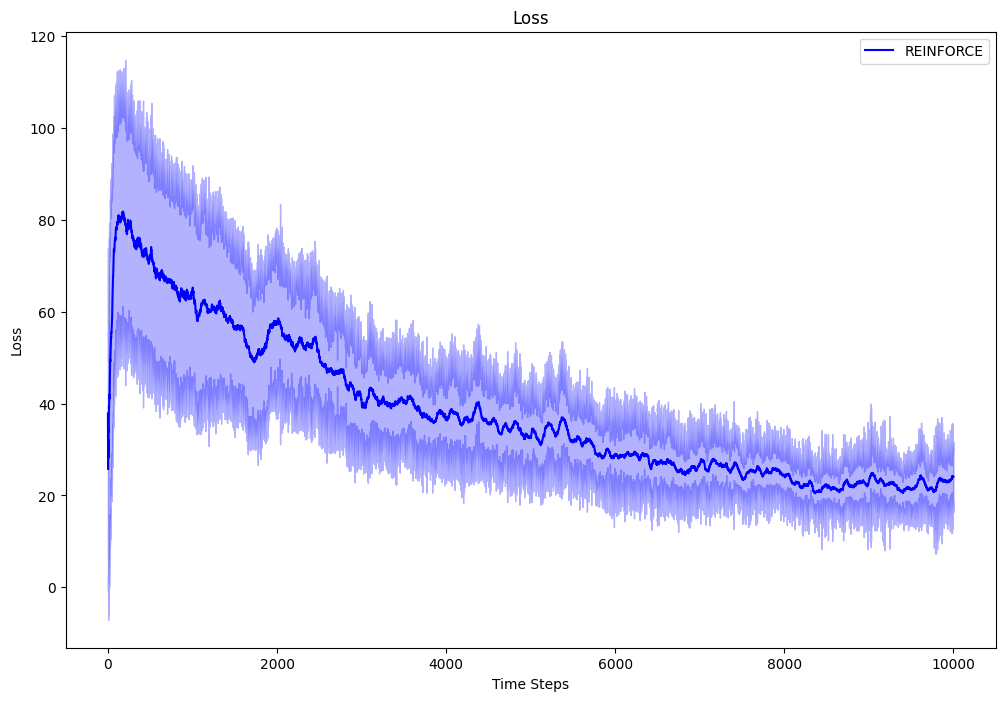

In [23]:
plot_curves([np.array(reinforce_returns)], ['REINFORCE'], ['r'], 'Return', 'Return', smoothing = True)
plot_curves([np.array(reinforce_losses)], ['REINFORCE'], ['b'], 'Loss', 'Loss', smoothing = True)

## Part (b): REINFORCE with baseline (page 330)

In this version of REINFORCE, we additionally learn a critic network (state-value function) to act as the baseline. In this context, the policy is sometimes referred to as the "actor", but the textbook reserves this terminology for the algorithm in part (c).

In [19]:
# Policy and value networks
class REINFORCEBaselineNet(nn.Module):
    def __init__(self, observation_dim=3, hidden_dim=128, action_dim=4):
        super(REINFORCEBaselineNet, self).__init__()

        """ YOUR CODE HERE:
                Implement the critic network here. The architecture should be:

                Layer 1: Linear, input size 3, output size 128
                Activation 1: ReLU
                Layer 2: Linear, input size 128, output size 1
                Activation 2: Identity (or none)
        """
        self.critic_in = nn.Linear(observation_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.critic_out = nn.Linear(hidden_dim, 1)

        """ YOUR CODE HERE:
                Implement the actor network here. The architecture should be (same as before):

                Layer 1: Linear, input size 3, output size 128
                Activation 1: ReLU
                Layer 2: Linear, input size 128, output size 4
                Activation 2: Softmax
        """
        self.actor_in = nn.Linear(observation_dim, hidden_dim)
        # reuse self.relu
        self.actor_out = nn.Linear(hidden_dim, action_dim)
        self.softmax = nn.Softmax()


    def forward(self, x):
        """ YOUR CODE HERE:
                Implement the forward propagation for both actor and critic networks
        """

        critic_x = self.critic_in(x)
        critic_x = self.relu(critic_x)
        state_value = self.critic_out(critic_x)

        actor_x = self.actor_in(x)
        actor_x = self.relu(actor_x)
        actor_x = self.actor_out(actor_x)
        action_probs = self.softmax(actor_x)

        return state_value, action_probs

In [20]:
# REINFORCE-with-baseline agent
class REINFORCEBaselineAgent(object):
    def __init__(self):
        # Create the actor and critic networks
        self.policy_net = REINFORCEBaselineNet()

    def get_action(self, state):
        # Sample an action from the actor network, return the action and its log probability,
        # and return the state value according to the critic network
        state_tensor = torch.tensor(state).float().view(1, -1)
        state_value, action_probs = self.policy_net(state_tensor)
        m = Categorical(action_probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        return action.item(), log_prob, state_value

In [13]:
# REINFORCE-with-baseline training loop
class REINFORCEBaselineAgentTrainer(object):
    def __init__(self, agent, env, params):
        # Agent object
        self.agent = agent

        # Environment object
        self.env = env

        # Training parameters
        self.params = params

        # Lists to store the log probabilities, state values, and rewards for one episode
        self.saved_log_probs = []
        self.saved_state_values = []
        self.saved_rewards = []

        # Gamma
        self.gamma = params['gamma']

        # Create the optimizer
        """ YOUR CODE HERE:
                Implement the Adam optimizer with the learning rate in params
        """
        self.optimizer = torch.optim.Adam(agent.policy_net.parameters(), lr=params['learning_rate'])

    @staticmethod
    def compute_state_feature(state):
        return [state[0] / 10, state[1] / 10, 1]

    def update_agent_policy_network(self):
        # List to store the policy loss for each time step
        policy_loss = []

        # List to store the value loss for each time step
        value_loss = []

        # List to store the return for each time step
        returns = deque()

        """ YOUR CODE HERE:
                Compute the return for each time step

                Hint: We usually compute the return from the end. Remember to append it
                      correctly. You can use "returns.appendleft(G)"
        """
        # Compute returns for every time step

        G = 0
        for reward in reversed(self.saved_rewards):
            G = self.gamma * G + reward
            returns.appendleft(G)

        returns = torch.tensor(returns)

        """ YOUR CODE HERE:
                We now have the return, state value, and log probability for each time step.
                Compute the `policy loss' and `value loss' for each time step
                (whose gradients appear in the pseudocode).
        """
        for log_prob, val, r in zip(self.saved_log_probs, self.saved_state_values, returns):
            # Compute the policy and value loss for each time step
            policy_loss.append(-log_prob * (r - val.detach().item())) # detach state value, don't optimize value network with policy loss
            value_loss.append(F.mse_loss(val[0, 0], r))

        # Compute the total loss
        total_loss = torch.stack(policy_loss).sum() + torch.stack(value_loss).sum()

        """ YOUR CODE HERE:
                Implement one step of backpropagation (gradient descent)
        """
        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()

        # After backpropagation, clear the data
        del self.saved_log_probs[:]
        del self.saved_state_values[:]
        del self.saved_rewards[:]

        return returns[0].item(), total_loss.item()

    def rollout(self):
        """ Function to collect one episode from the environment
        """

        """ YOUR CODE HERE:
                Implement the code to collect one episode.

                Collect the rewards, state valuess and log probabilities, which should be stored in
                "self.saved_rewards", "self.saved_state_values", and "self.saved_log_probs" respectively.
        """

        done = False
        state, info = self.env.reset()
        while not done:
            action, log_prob, state_value = self.agent.get_action(self.compute_state_feature(state))
            next_state, reward, terminated, truncated, info = self.env.step(action)
            self.saved_log_probs.append(log_prob)
            self.saved_rewards.append(reward)
            self.saved_state_values.append(state_value)

            done = terminated or truncated
            state = next_state

    def run_train(self):
        # Lists to store the returns and losses during the training
        train_returns = []
        train_losses = []

        # Training loop
        ep_bar = tqdm.trange(self.params['num_episodes'])
        for ep in ep_bar:
            """ YOUR CODE HERE:
                    Implement the REINFORCE-with-baseline algorithm here.
            """
            # Collect one episode
            self.rollout()

            # Update the policy using the collected episode
            G, loss = self.update_agent_policy_network()

            # Save the return and loss
            train_returns.append(G)
            train_losses.append(loss)

            # Add description
            ep_bar.set_description(f"Episode: {ep} | Return: {G} | Loss: {loss:.2f}")

        return train_returns, train_losses

In [57]:
if __name__ == "__main__":
    my_env = FourRooms()

    train_params = {
        'num_episodes': 10000,
        'num_trials': 10,
        'learning_rate': 1e-3,
        'gamma': 0.99
    }

    reinforce_baseline_returns = []
    reinforce_baseline_losses = []
    for _ in range(train_params['num_trials']):
        my_agent = REINFORCEBaselineAgent()
        my_trainer = REINFORCEBaselineAgentTrainer(my_agent, my_env, train_params)
        returns, losses = my_trainer.run_train()

        reinforce_baseline_returns.append(returns)
        reinforce_baseline_losses.append(losses)

  0%|          | 0/10000 [00:00<?, ?it/s]/opt/homebrew/lib/python3.11/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Episode: 9999 | Return: 0.7856781482696533 | Loss: 0.30: 100%|██████████| 10000/10000 [03:45<00:00, 44.35it/s]   
Episode: 9999 | Return: 0.770043134689331 | Loss: 0.68: 100%|██████████| 10000/10000 [05:31<00:00, 30.20it/s]     
Episode: 9999 | Return: 0.6235253810882568 | Loss: -0.74: 100%|██████████| 10000/10000 [03:48<00:00, 43.85it/s]  
Episode: 9999 | Return: 0.7547193169593811 | Loss: -0.09: 100%|██████████| 10000/10000 [03:56<00:00, 42.37it/s]  
Episode: 9999 | Return: 0.7623426914215088 | Loss: 0.82: 100%|██████████| 10000/10000 [03:58<00:00, 41.94it/s]   
Episode: 9999 | Return: 0.7936142683029175 | Loss: 1.21: 100%|██████████| 10000/10000 [04:05<00:00, 40.74it/s]   
Episode: 9999 | Return: 0.717730522

### Plot learning and loss curves

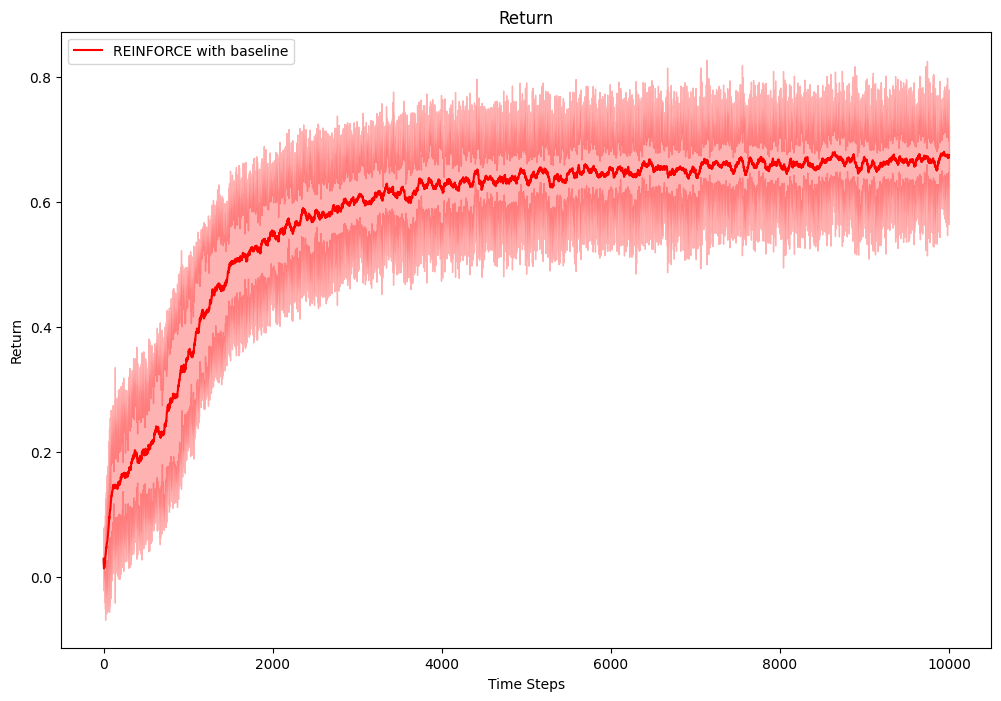

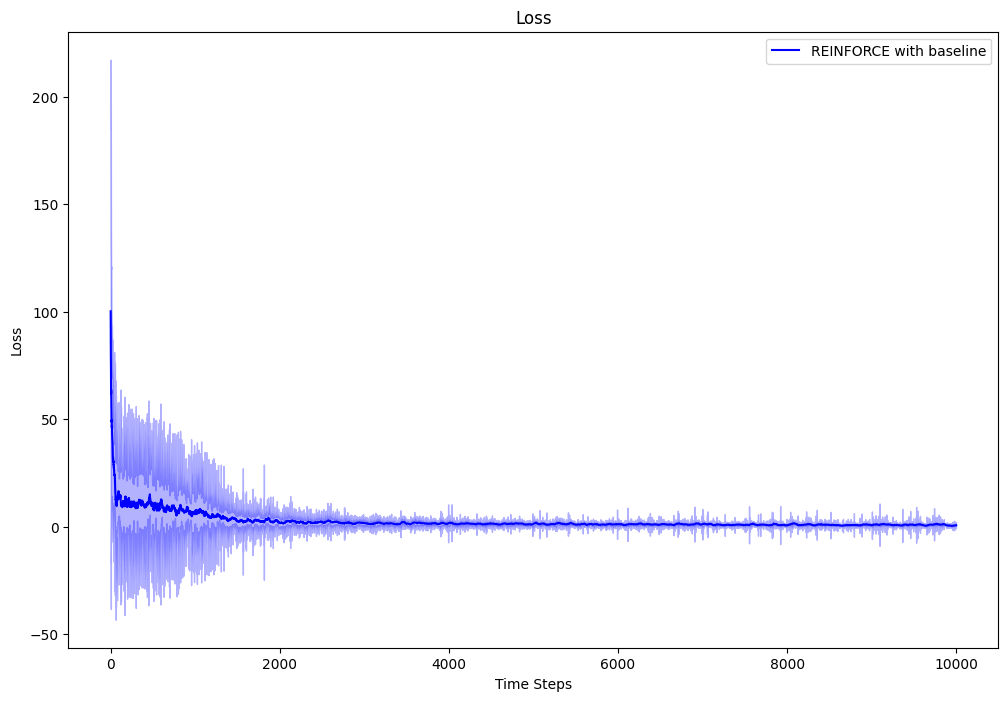

In [58]:
plot_curves([np.array(reinforce_baseline_returns)], ['REINFORCE with baseline'], ['r'], 'Return', 'Return', smoothing = True)
plot_curves([np.array(reinforce_baseline_losses)], ['REINFORCE with baseline'], ['b'], 'Loss', 'Loss', smoothing = True)

## Part (c): One-step actor-critic (page 332)

Implement one-step actor-critic and apply it to Four Rooms, similar to the previous parts. Most of the previous code is reusable, although notice that updates can technically occur after every environment step (instead of waiting until the end of the episode), since REINFORCE uses a Monte-Carlo learning target whereas actor-critic uses the one-step TD error.

In [70]:
class ActorCriticAgentTrainer(object):
    def __init__(self, agent, env, params):
        # Agent object
        self.agent = agent

        # Environment object
        self.env = env

        # Training parameters
        self.params = params

        # Lists to store the log probabilities, state values, and rewards for one episode
        self.saved_log_probs = []
        self.saved_state_values = []
        self.saved_rewards = []
        self.saved_bootstrap_returns = []

        # Gamma
        self.gamma = params['gamma']

        # Create the optimizer
        """ YOUR CODE HERE:
                Implement the Adam optimizer with the learning rate in params
        """
        self.optimizer = torch.optim.Adam(agent.policy_net.parameters(), lr=params['learning_rate'])

    @staticmethod
    def compute_state_feature(state):
        return [state[0] / 10, state[1] / 10, 1]

    def update_actor_critic_networks(self):

        # List to store the policy loss for each time step
        policy_loss = []

        # List to store the value loss for each time step
        value_loss = []

        """ YOUR CODE HERE:
                We now have the return, state value, and log probability for each time step.
                Compute the `policy loss' and `value loss' for each time step
                (whose gradients appear in the pseudocode).
        """
        for log_prob, val, r in zip(self.saved_log_probs, self.saved_state_values, self.saved_bootstrap_returns):
            # Compute the policy and value loss for each time step
            # (joint optimization)
            # policy loss is -log_prob * td_error (negative bc pytorch minimizes)
            policy_loss.append(-log_prob * (r - val.detach().item())) # detach state value, don't optimize value network with policy loss

            # saved bootstrapped return already has next state value detached, so we only differentiate with respect to V(s, w)
            # grad MSE loss = (V(s,w) - r + gamma * V(s', w)) * grad V(s,w)
            value_loss.append(F.mse_loss(val, torch.tensor(r)))

        # Compute the total loss
        total_loss = torch.stack(policy_loss).sum() + torch.stack(value_loss).sum()

        """ YOUR CODE HERE:
                Implement one step of backpropagation (gradient descent)
        """
        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()

        G = 0
        for reward in reversed(self.saved_rewards):
            G = self.gamma * G + reward

        # After backpropagation, clear the data
        del self.saved_log_probs[:]
        del self.saved_state_values[:]
        del self.saved_rewards[:]
        del self.saved_bootstrap_returns[:]

        return G, total_loss.item()

    def rollout(self):
        """ Function to collect one episode from the environment
        """

        """ YOUR CODE HERE:
                Implement the code to collect one episode.

                Collect the rewards, state valuess and log probabilities, which should be stored in
                "self.saved_rewards", "self.saved_state_values", and "self.saved_log_probs" respectively.
        """

        done = False
        state, info = self.env.reset()
        while not done:
            action, log_prob, state_value = self.agent.get_action(self.compute_state_feature(state))
            next_state, reward, terminated, truncated, info = self.env.step(action)
            self.saved_log_probs.append(log_prob)
            self.saved_rewards.append(reward)
            self.saved_state_values.append(state_value)

            if not done:
                _, _, next_state_value = self.agent.get_action(self.compute_state_feature(next_state))
                # detach next state value, we don't want to differentiate with respect to V(s', w), only with regard to log probs
                self.saved_bootstrap_returns.append(reward + self.gamma * next_state_value.detach().item())
            else:
                self.saved_bootstrap_returns.append(reward)

            done = terminated or truncated
            state = next_state

    def run_train(self):
        # Lists to store the returns and losses during the training
        train_returns = []
        train_losses = []

        # Training loop
        ep_bar = tqdm.trange(self.params['num_episodes'])
        for ep in ep_bar:
            """ YOUR CODE HERE:
                    Implement the Actor-Critic algorithm here.
            """
            # Collect one episode
            self.rollout()

            # update both network weights
            G, loss = self.update_actor_critic_networks()

            # Save the return and loss
            train_returns.append(G)
            train_losses.append(loss)

            # Add description
            ep_bar.set_description(f"Episode: {ep} | Return: {G} | Loss: {loss:.2f}")

        return train_returns, train_losses

In [72]:
""" YOUR CODE HERE:
        Implement one-step actor-critic
"""
if __name__ == "__main__":
    my_env = FourRooms()

    train_params = {
        'num_episodes': 10000,
        'num_trials': 1,
        'learning_rate': 1e-3,
        'gamma': 0.99
    }

    actor_critic_returns = []
    actor_critic_losses = []
    for _ in range(train_params['num_trials']):
        my_agent = REINFORCEBaselineAgent() # agent is the same
        my_trainer = ActorCriticAgentTrainer(my_agent, my_env, train_params)
        returns, losses = my_trainer.run_train()

        actor_critic_returns.append(returns)
        actor_critic_losses.append(losses)

  0%|          | 0/10000 [00:00<?, ?it/s]/var/folders/g5/28nf4n8j4vsgwnnc4jgwrp700000gn/T/ipykernel_86922/4035728635.py:52: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss.append(F.mse_loss(val, torch.tensor(r)))
Episode: 9999 | Return: 0.5696012024771592 | Loss: 16099.01: 100%|██████████| 10000/10000 [09:44<00:00, 17.10it/s] 


In [75]:
# run 4 more trials
train_params['num_trials'] = 4

for _ in range(train_params['num_trials']):
    my_agent = REINFORCEBaselineAgent() # agent is the same
    my_trainer = ActorCriticAgentTrainer(my_agent, my_env, train_params)
    returns, losses = my_trainer.run_train()

    actor_critic_returns.append(returns)
    actor_critic_losses.append(losses)

  0%|          | 0/10000 [00:00<?, ?it/s]/var/folders/g5/28nf4n8j4vsgwnnc4jgwrp700000gn/T/ipykernel_86922/4035728635.py:52: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss.append(F.mse_loss(val, torch.tensor(r)))
Episode: 9999 | Return: 0.7856781408072188 | Loss: 12415.19: 100%|██████████| 10000/10000 [11:50<00:00, 14.07it/s] 
Episode: 1652 | Return: 0.0 | Loss: -0.55:  17%|█▋        | 1653/10000 [05:40<28:39,  4.85it/s]                 


KeyboardInterrupt: 

### Plot learning and loss curves

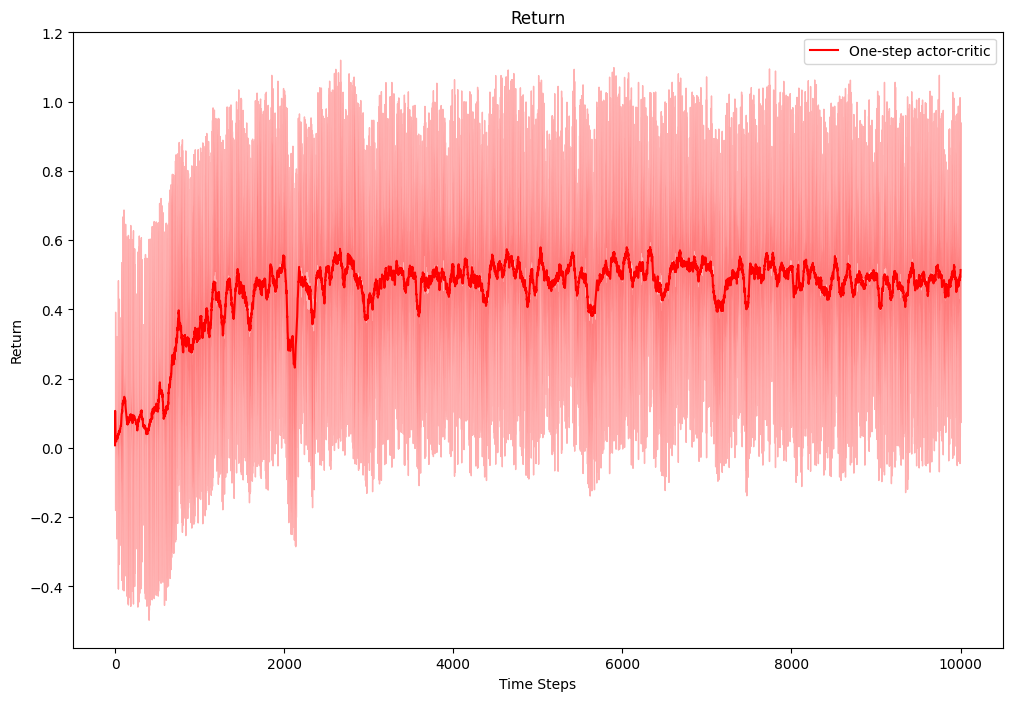

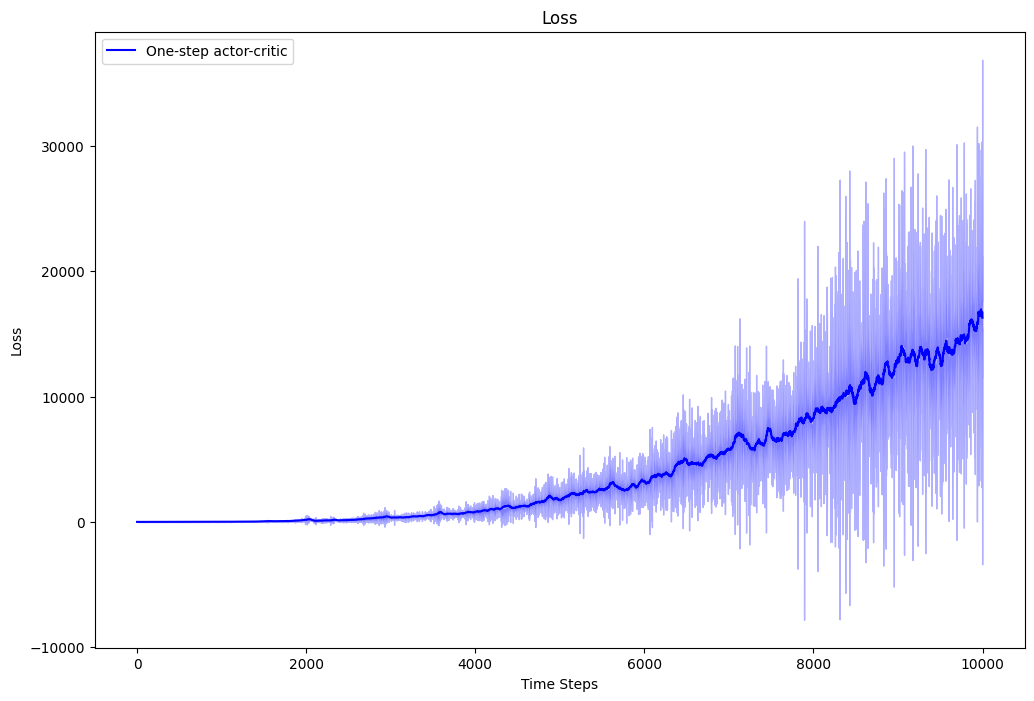

In [76]:
plot_curves([np.array(actor_critic_returns)], ['One-step actor-critic'], ['r'], 'Return', 'Return', smoothing = True)
plot_curves([np.array(actor_critic_losses)], ['One-step actor-critic'], ['b'], 'Loss', 'Loss', smoothing = True)

## Part (d): Compare REINFORCE, REINFORCE with baseline, and one-step actor-critic.

Compare the performance of these three methods.

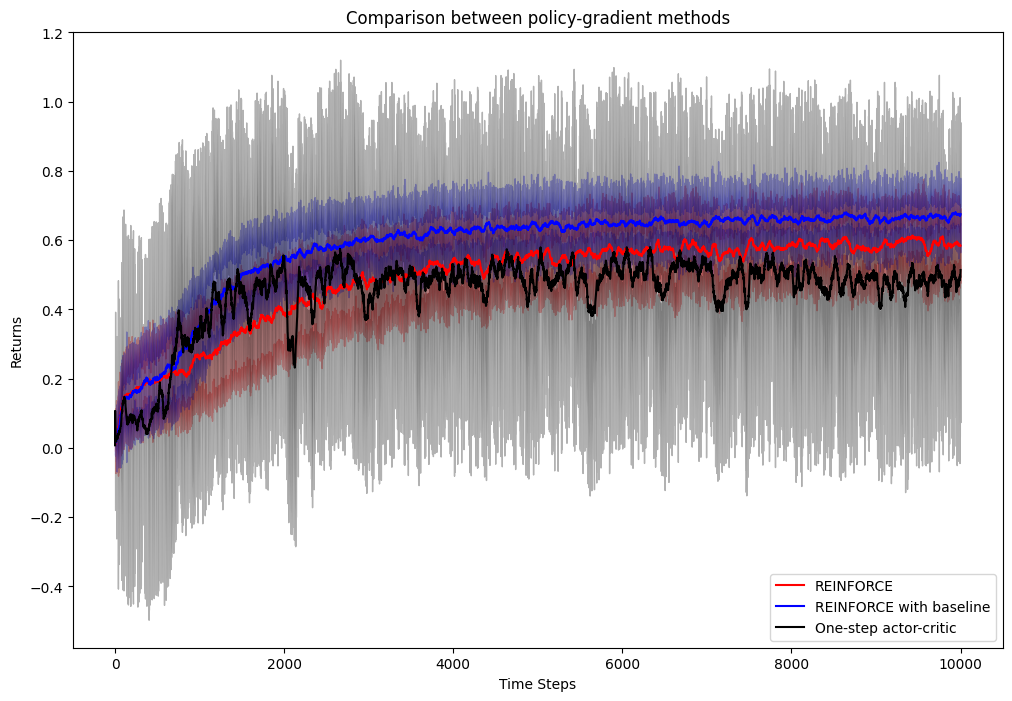

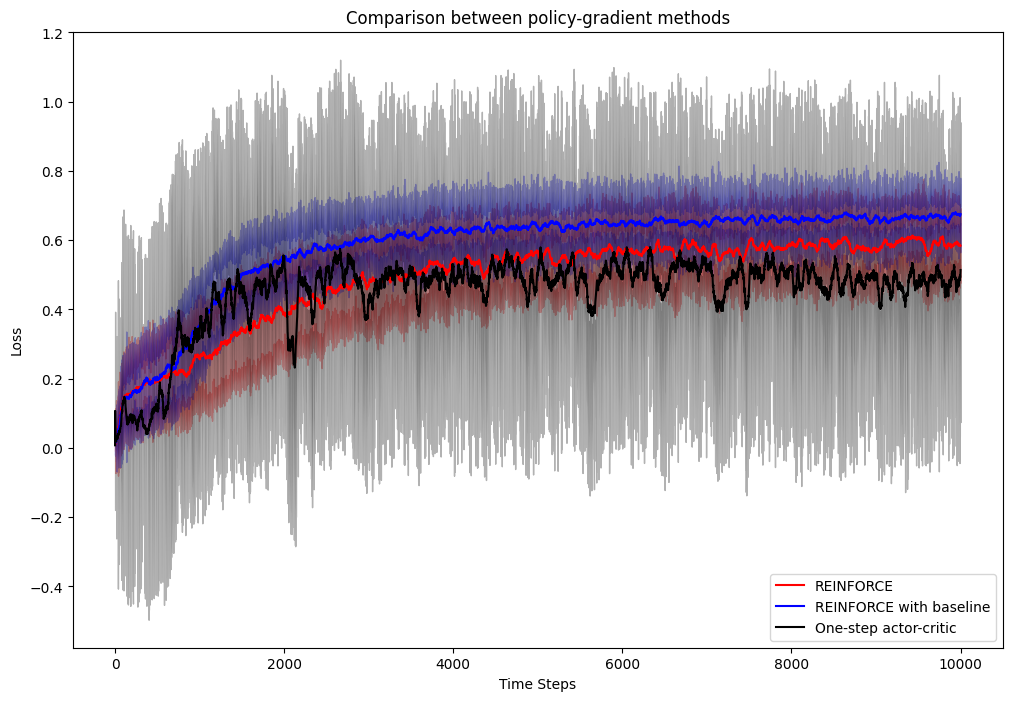

In [77]:
plot_curves([np.array(reinforce_returns), np.array(reinforce_baseline_returns), np.array(actor_critic_returns)],
            ['REINFORCE', 'REINFORCE with baseline', 'One-step actor-critic'],
            ['r', 'b', 'k'], 'Returns', "Comparison between policy-gradient methods")
plot_curves([np.array(reinforce_returns), np.array(reinforce_baseline_returns), np.array(actor_critic_returns)],
            ['REINFORCE', 'REINFORCE with baseline', 'One-step actor-critic'],
            ['r', 'b', 'k'], 'Loss', "Comparison between policy-gradient methods")

## Part (e): Advanced policy-gradient algorithms

Many deep policy-gradient algorithms have been proposed in the past 10 years. Read about and implement one or more of these from scratch (e.g., DDPG, TD3, PPO, SAC) and evaluate them on Four Rooms. Compare with the methods above and discuss your findings.

We recommend that you first read about some of these algorithms on OpenAI's "Spinning up in deep RL" pages, although you should not directly use their implementations in this assignment.\
https://spinningup.openai.com/en/latest/user/algorithms.html

In [10]:
class SharedActorCriticNet(nn.Module):
    def __init__(self, observation_dim=3, hidden_dim=128, action_dim=4):
        super(SharedActorCriticNet, self).__init__()

        """ YOUR CODE HERE:
                Implement the critic network here. The architecture should be:

                Layer 1: Linear, input size 3, output size 128
                Activation 1: ReLU
                Layer 2: Linear, input size 128, output size 1
                Activation 2: Identity (or none)
        """
        self.shared_in = nn.Linear(observation_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.critic_out = nn.Linear(hidden_dim, 1)

        """ YOUR CODE HERE:
                Implement the actor network here. The architecture should be (same as before):

                Layer 1: Linear, input size 3, output size 128
                Activation 1: ReLU
                Layer 2: Linear, input size 128, output size 4
                Activation 2: Softmax
        """
        # reuse shared_in, self.relu
        self.actor_out = nn.Linear(hidden_dim, action_dim)
        self.softmax = nn.Softmax()


    def forward(self, x):
        """ YOUR CODE HERE:
                Implement the forward propagation for both actor and critic networks
        """
        # shared feature extraction layer
        shared_x = self.shared_in(x)
        shared_x = self.relu(shared_x)

        # Compute state value estimates (critic network)
        state_value = self.critic_out(shared_x)

        # Compute action probabilities (actor network)
        actor_x = self.actor_out(shared_x)
        action_probs = self.softmax(actor_x)

        return state_value, action_probs

In [11]:
torch.autograd.set_detect_anomaly(False)

In [15]:
Batch = namedtuple(
    'Batch', ('states', 'actions', 'rewards', 'next_states', 'dones', 'log_probs', 'state_values')
)


class ReplayMemory:
    def __init__(self, max_size, state_size):
        """Replay memory implemented as a circular buffer.

        Experiences will be removed in a FIFO manner after reaching maximum
        buffer size.

        Args:
            - max_size: Maximum size of the buffer
            - state_size: Size of the state-space features for the environment
        """
        self.max_size = max_size
        self.state_size = state_size

        # Preallocating all the required memory, for speed concerns
        self.states = torch.empty((max_size, state_size))
        self.actions = torch.empty((max_size, 1), dtype=torch.long)
        self.rewards = torch.empty((max_size, 1))
        self.next_states = torch.empty((max_size, state_size))
        self.dones = torch.empty((max_size, 1), dtype=torch.bool)
        # self.boostrap_returns = torch.empty((max_size, 1))
        self.log_probs = torch.empty((max_size, 1))
        self.state_values = torch.empty((max_size, 1))

        # Pointer to the current location in the circular buffer
        self.idx = 0
        # Indicates number of transitions currently stored in the buffer
        self.size = 0

    def add(self, state, action, reward, next_state, done, log_prob, state_value):
        """Add a transition to the buffer.

        :param state: 1-D np.ndarray of state-features
        :param action: Integer action
        :param reward: Float reward
        :param next_state: 1-D np.ndarray of state-features
        :param done: Boolean value indicating the end of an episode
        :param bootstrap_return: reward + critic(s')
        :param log_prob log of probability for selected action
        :param state_value s
        """

        if self.size == self.max_size:
            return

        # YOUR CODE HERE: Store the input values into the appropriate
        # attributes, using the current buffer position `self.idx`

        self.states[self.idx] = torch.tensor(state)
        self.actions[self.idx] = action
        self.rewards[self.idx] = reward
        self.next_states[self.idx] = torch.tensor(next_state)
        self.dones[self.idx] = done

        # self.boostrap_returns[self.idx] = bootstrap_return
        self.log_probs[self.idx] = log_prob
        self.state_values[self.idx] = state_value

        # DO NOT EDIT
        # Circulate the pointer to the next position
        self.idx = (self.idx + 1) % self.max_size
        # Update the current buffer size
        self.size = min(self.size + 1, self.max_size)

    def get_all(self):
        return Batch(
            self.states[:self.size],
            self.actions[:self.size],
            self.rewards[:self.size],
            self.next_states[:self.size],
            self.dones[:self.size],
            self.log_probs[:self.size],
            self.state_values[:self.size]
        )


    def sample(self, batch_size) -> Batch:
        """Sample a batch of experiences.

        If the buffer contains less that `batch_size` transitions, sample all
        of them.

        :param batch_size: Number of transitions to sample
        :rtype: Batch
        """
        # YOUR CODE HERE: Randomly sample an appropriate number of
        # transitions *without replacement*. If the buffer contains less than
        # `batch_size` transitions, return all of them. The return type must
        # be a `Batch`.

        sample_size = min(self.size, batch_size)

        sample_indices = torch.randint(0, self.size, size=(sample_size,), dtype=torch.long)
        batch = Batch(
            self.states[sample_indices],
            self.actions[sample_indices],
            self.rewards[sample_indices],
            self.next_states[sample_indices],
            self.dones[sample_indices],
            self.log_probs[sample_indices],
            self.state_values[sample_indices]
        )

        return batch

    def populate(self, env, num_steps):
        """Populate this replay memory with `num_steps` from the random policy.

        :param env: Gymnasium environment
        :param num_steps: Number of steps to populate the replay memory
        """

        # YOUR CODE HERE: Run a random policy for `num_steps` time-steps and
        # populate the replay memory with the resulting transitions.
        # Hint: Use the self.add() method.

        # Random policy
        def policy(state):
            return env.action_space[torch.randint(len(env.action_space))]

        # Basic gym loop
        state, info = env.reset()
        for i in range(num_steps):
            action = policy(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            self.add(state, action, reward, next_state, terminated)

            if terminated or truncated:
                state, info = env.reset()
            else:
                state = next_state

    def clear(self):
        self.idx = 0
        self.size = 0

In [16]:
# PPO agent - use joint or separate actor critic networks
class PPOAgent(object):
    def __init__(self, shared_backbone=False):
        # Create the actor and critic networks
        if shared_backbone:
            self.policy_net = SharedActorCriticNet()
            # cached target net
            self.target_net = SharedActorCriticNet()
        else:
            self.policy_net = REINFORCEBaselineNet() # basically just an actor critic net
            self.target_net = REINFORCEBaselineNet()

    def get_action(self, state):
        # Sample an action from the actor network, return the action and its log probability,
        # and return the state value according to the critic network
        state_tensor = torch.tensor(state).float().view(1, -1)
        state_value, action_probs = self.policy_net(state_tensor)
        m = Categorical(action_probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        return action.item(), log_prob, state_value

    def get_estimates(self, state):
        """
        Returns state value estimate and entropy of action distribution at a given state or batch of states
        """
        # state_tensor = torch.tensor(state).float().view(1, -1)
        state_value, action_probs = self.policy_net(state)
        m = Categorical(action_probs)
        return state_value, m.entropy()

    def update_target_net(self):
        # cache the target network before training iterations to constrain probability ratio
        self.target_net.load_state_dict(self.policy_net.state_dict())

    @torch.no_grad
    def get_action_probability(self, state, action):
        # state_tensor = torch.tensor(state).float().view(1, -1)

        # _, old_action_probs = self.target_net(state_tensor)
        _, current_action_probs = self.policy_net(state)
        return current_action_probs[..., action]




In [17]:
# PPO Trainer
class PPOAgentTrainer(object):
    def __init__(self, agent: PPOAgent, env: FourRooms | gym.Env, params):
        # Agent object
        self.agent = agent

        # Environment object
        self.env = env

        # Training parameters
        self.params = params

        # Lists to store the log probabilities, state values, and rewards for one episode
        self.saved_log_probs = []
        self.saved_state_values = []
        self.saved_rewards = []
        self.saved_bootstrap_returns = []
        self.replay_buffer = ReplayMemory(max_size=params['buffer_size'], state_size=3)

        # Gamma
        self.gamma = params['gamma']

        # epsilon for PPO-Clip
        self.epsilon = params['epsilon']

        self.k_epochs = params['epochs_per_update']

        self.entropy_coef = params['entropy_coef']


        # Create the optimizer
        """ YOUR CODE HERE:
                Implement the Adam optimizer with the learning rate in params
        """
        self.optimizer = torch.optim.Adam(agent.policy_net.parameters(), lr=params['learning_rate'])

    @staticmethod
    def compute_state_feature(state):
        return [state[0] / 10, state[1] / 10, 1]

    def update_actor_critic_networks(self):

        # List to store the policy loss for each time step
        # policy_loss = []

        # List to store the value loss for each time step
        # value_loss = []

        # entropy_bonus = 0

        dataset = self.replay_buffer.get_all()

        # Compute discounted returns at each time step (rewards-to-go)
        G = 0
        returns = deque()

        for reward, done in zip(reversed(dataset.rewards), reversed(dataset.dones)):
            if done:
                # end of episode, reset discounted return calculation
                G = 0

            G = self.gamma * G + reward
            returns.appendleft(G)

        returns = torch.tensor(returns)
        print("Updating networks, returns: ", returns)

        for epoch in range(self.k_epochs):
            # for state, action, log_prob, val, r in zip(dataset.states, dataset.actions, dataset.log_probs, dataset.state_values, returns):
            # Compute the policy and value loss for each time step
            # (joint optimization)
            advantage = (returns - dataset.state_values.detach()) # detach state value, don't optimize value network with policy loss

            # Probability ratio of selecting action at s, use log_prob for pi_theta_old
            ratio_t = self.agent.get_action_probability(dataset.states, dataset.actions) / torch.exp(dataset.log_probs.detach())

            # Unclipped surrogate advantage
            unclipped_adv = ratio_t * advantage

            # Clipped surrogate advantage
            clipped_adv = torch.clamp(ratio_t, min=(1 - self.epsilon), max=(1 + self.epsilon))

            # Choose the minimum of the two (in the negative direction, if we choose a bad action, it should be bad)
            # unclipped chosen when ratio > 1+epsilon and advantage is negative
            # or when ratio < 1 - epsilon and advantage is positive
            # negative sign because torch Adam minimizes
            policy_loss = -torch.min(unclipped_adv, clipped_adv)

            latest_state_values, entropy_bonus = self.agent.get_estimates(dataset.states)

            # Critic / value function estimate loss based on monte carlo return
            value_loss = F.mse_loss(latest_state_values, returns.detach().unsqueeze(-1))

            # Compute the total loss
            total_loss = policy_loss.sum() + value_loss.sum() - (self.entropy_coef * entropy_bonus.sum())
            # total_loss = torch.stack(policy_loss).sum() + torch.stack(value_loss).sum() - entropy_bonus

            """ YOUR CODE HERE:
                    Implement one step of backpropagation (gradient descent)
            """
            self.optimizer.zero_grad()
            total_loss.backward()
            self.optimizer.step()

        # After backpropagation, clear the data
        self.replay_buffer.clear()
        # del self.saved_log_probs[:]
        # del self.saved_state_values[:]
        # del self.saved_rewards[:]
        # del self.saved_bootstrap_returns[:]

        return G, total_loss.item()

    def run_train(self):
        # Lists to store the returns and losses during the training
        train_returns = []
        train_losses = []

        self.replay_buffer.clear()

        # Training loop
        state, info = self.env.reset()
        done = False

        G, loss = 0, 0

        t_bar = tqdm.trange(self.params['train_timesteps'])
        for t in t_bar:
            """ YOUR CODE HERE:
                    Implement the Actor-Critic algorithm here.
            """
            # Collect one transition
            action, log_prob, state_value = self.agent.get_action(self.compute_state_feature(state))
            next_state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated

            state_tensor = self.compute_state_feature(state)

            self.replay_buffer.add(state_tensor, action, reward, self.compute_state_feature(next_state), done, log_prob, state_value)

            if not done:
                state = next_state
            else:
                # reset environment
                state, info = self.env.reset()
                done = False

            if t % self.params['update_frequency'] == 0: # PPO update every N iterations
                # update both network weights
                G, loss = self.update_actor_critic_networks()

                # Save the return and loss
                train_returns.append(G)
                train_losses.append(loss)

            # Add description
            t_bar.set_description(f"Timestep: {t} | Return: {G} | Loss: {loss:.2f}")

        return train_returns, train_losses

In [21]:
if __name__ == "__main__":

    my_env = FourRooms()

    train_params = {
        'num_episodes': 10000,
        'num_trials': 1,
        'learning_rate': 1e-3,
        'gamma': 0.99,
        'train_timesteps': 10000,
        'entropy_coef': 0.01,
        'buffer_size': my_env.max_time_steps * 4,
        'update_frequency': my_env.max_time_steps * 4,
        'epsilon': 0.2,
        'epochs_per_update': 5
    }

    ppo_returns = []
    ppo_losses = []
    for _ in range(train_params['num_trials']):
        my_agent = PPOAgent() # agent is the same
        my_trainer = PPOAgentTrainer(my_agent, my_env, train_params)
        returns, losses = my_trainer.run_train()

        ppo_returns.append(returns)
        ppo_losses.append(losses)

  0%|          | 0/10000 [00:00<?, ?it/s]/opt/homebrew/lib/python3.11/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
Timestep: 117 | Return: tensor([-1.]) | Loss: 1.31:   1%|          | 84/10000 [00:00<00:20, 490.09it/s]

Updating networks, returns:  tensor([-1.])


Timestep: 1835 | Return: tensor([-1.]) | Loss: 1.31:  18%|█▊        | 1802/10000 [00:02<00:11, 739.13it/s]

Updating networks, returns:  tensor([-99.0080, -98.9980, -98.9878,  ...,  -2.9701,  -1.9900,  -1.0000])


Timestep: 1835 | Return: tensor([-1.]) | Loss: 1.31:  18%|█▊        | 1802/10000 [00:21<00:11, 739.13it/s]

: 